In [1]:
import tensorflow as tf
import os
import collections
import time
import random
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import math

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
from PIL import Image
from tqdm import tqdm

#Custom Classes
from prep import Preparation
from gru_decoder import GRU_Decoder
from gru_encoder import GRU_Encoder
from cnn_encoder import CNN_Encoder

In [2]:
prep = Preparation()


In [3]:
image_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
image_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(image_input, hidden_layer)

In [4]:
with open("../dataset/best_captions.json", "r") as jf:
    data = json.loads(jf.read())

target_data = data['target_paths']
distractor_data = data['distractor_paths']
caption_data = data['best_captions'] 

In [5]:
edited_caption_data = []
for i in range(len(caption_data)):
    edited_caption_data.append(f'<start> {caption_data[i]} <end>')

In [6]:
#Split into train, val, and test set.
val_slice_index = int(len(target_data)*0.8)
test_slice_index = int(len(target_data)*0.9)

targ_name_train, targ_name_val, targ_name_test = target_data[:val_slice_index], target_data[val_slice_index:test_slice_index], target_data[test_slice_index:]

dis_name_train, dis_name_val, dis_name_test = distractor_data[:val_slice_index], distractor_data[val_slice_index:test_slice_index], distractor_data[test_slice_index:]

captions_train, captions_val, captions_test = edited_caption_data[:val_slice_index], edited_caption_data[val_slice_index:test_slice_index], edited_caption_data[test_slice_index:]


<start> He has a goatee. <end>


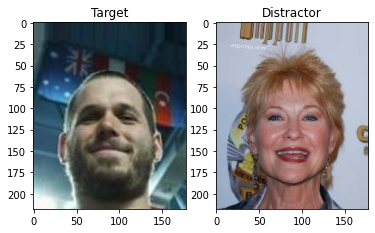

In [7]:
img_A = mpimg.imread(f"../dataset/prep_data/{targ_name_test[0]}.jpg")
img_B = mpimg.imread(f"../dataset/prep_data/{dis_name_test[0]}.jpg")
print(captions_test[0])
# display images
fig, ax = plt.subplots(1,2)
ax[0].title.set_text("Target")
ax[0].imshow(img_A)
ax[1].title.set_text("Distractor")
ax[1].imshow(img_B)

In [8]:
#Tokenize the captions
top_v = 45

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_v,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(captions_train)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(captions_train)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = 5

In [9]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 1024
units = 512
vocab_size = top_v + 1
num_steps = len(targ_name_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((targ_name_train, dis_name_train, cap_vector))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2, item3: tf.numpy_function(
          prep.map_func_oracle, [item1, item2, item3], [tf.float32, tf.float32, tf.int32]))

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
decoder = GRU_Decoder(embedding_dim, units, vocab_size)
encoder = CNN_Encoder(embedding_dim)

optimizer = tf.keras.optimizers.Adam()

loss_plot = []

In [12]:
checkpoint_path = "./checkpointsh2a/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=30)

In [13]:
@tf.function
def train_step(u, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      #could be a serious problem -- most likely! Exciting
      features = encoder(u)
  
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          
          pred_probs = tf.nn.softmax(predictions)
          with tape.stop_recording():
            row_indices = tf.reshape(tf.range(target.shape[0]),(target.shape[0],1))
            col_indices = tf.reshape(target[:,i], (target.shape[0],1))
            full_indices = tf.concat([row_indices,col_indices],axis=1)
          
          log_probs = tf.math.log(pred_probs)
          loss_ = tf.gather_nd(log_probs, full_indices)
          
          loss += -tf.reduce_mean(loss_)

          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [14]:
EPOCHS = 7

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (targ_tensor, dis_tensor, target)) in enumerate(dataset):
        u = tf.concat([targ_tensor, dis_tensor], -1)

        batch_loss, t_loss = train_step(u, target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
              
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 3.3440
Epoch 1 Batch 100 Loss 0.5167
Epoch 1 Batch 200 Loss 0.5452
Epoch 1 Batch 300 Loss 0.4372
Epoch 1 Batch 400 Loss 0.3084
Epoch 1 Batch 500 Loss 0.3490
Epoch 1 Loss 0.517478
Time taken for 1 epoch 257.0190460681915 sec

Epoch 2 Batch 0 Loss 0.4513
Epoch 2 Batch 100 Loss 0.2783
Epoch 2 Batch 200 Loss 0.3038
Epoch 2 Batch 300 Loss 0.2291
Epoch 2 Batch 400 Loss 0.1453
Epoch 2 Batch 500 Loss 0.2169
Epoch 2 Loss 0.249815
Time taken for 1 epoch 233.52725887298584 sec

Epoch 3 Batch 0 Loss 0.1825
Epoch 3 Batch 100 Loss 0.2429
Epoch 3 Batch 200 Loss 0.1275
Epoch 3 Batch 300 Loss 0.1294
Epoch 3 Batch 400 Loss 0.1440
Epoch 3 Batch 500 Loss 0.1465
Epoch 3 Loss 0.156738
Time taken for 1 epoch 234.73671698570251 sec

Epoch 4 Batch 0 Loss 0.1723
Epoch 4 Batch 100 Loss 0.1405
Epoch 4 Batch 200 Loss 0.1503
Epoch 4 Batch 300 Loss 0.0668
Epoch 4 Batch 400 Loss 0.0866
Epoch 4 Batch 500 Loss 0.0528
Epoch 4 Loss 0.109243
Time taken for 1 epoch 235.97196102142334 sec

Epoch 5 Batch

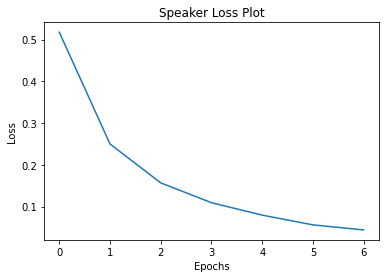

In [51]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Speaker Loss Plot')
plt.show()

In [20]:
def evaluate(targ, dis):
    # attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(prep.load_image(targ)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    targ_img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    temp_input = tf.expand_dims(prep.load_image(dis)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    dis_img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    u = tf.concat([targ_img_tensor_val, dis_img_tensor_val], -1)

    features = encoder(u)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, 16

        dec_input = tf.expand_dims([predicted_id], 0)

    # attention_plot = attention_plot[:len(result), :]
    return result, 5

In [21]:
import time
def show_test(num):
    result, attention_plot = evaluate(f"../dataset/prep_data/{target_data[num]}.jpg", f"../dataset/prep_data/{distractor_data[num]}.jpg")
    print('Utterance:', ' '.join(result))
    img_A = mpimg.imread(f"../dataset/prep_data/{target_data[num]}.jpg")
    img_B = mpimg.imread(f"../dataset/prep_data/{distractor_data[num]}.jpg")

    rand_n = random.uniform(0,1)

    if rand_n < 0.5:
        t = 0
        d = 1
    else:
        t = 1
        d = 0
    fig, ax = plt.subplots(1,2)
    ax[t].imshow(img_A)
    ax[d].imshow(img_B)

    return t

In [22]:
import time
def show_test_custom(im1, im2):
    result, attention_plot = evaluate(f"../dataset/custom/{im1}.jpg", f"../dataset/custom/{im2}.jpg")
    print('Utterance:', ' '.join(result))
    img_A = mpimg.imread(f"../dataset/custom/{im1}.jpg")
    img_B = mpimg.imread(f"../dataset/custom/{im2}.jpg")

    rand_n = random.uniform(0,1)

    if rand_n < 0.5:
        t = 0
        d = 1
    else:
        t = 1
        d = 0
    fig, ax = plt.subplots(1,2)
    ax[t].imshow(img_A)
    ax[d].imshow(img_B)

    return t

Utterance: she has brown hair <end>


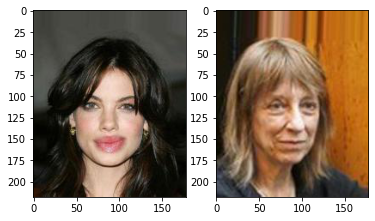

In [23]:
t = show_test(11)

In [24]:
if t == 0:
    print("The target is on the left")
else:
    print("The target is on the right")

The target is on the left


Utterance: he has a receding hairline


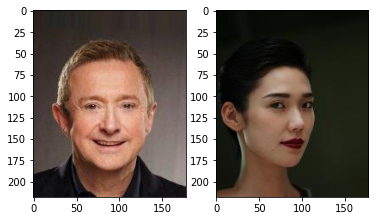

In [25]:
t = show_test(900)

In [26]:
if t == 0:
    print("The target is on the left")
else:
    print("The target is on the right")

The target is on the left


Utterance: he has black hair <end>


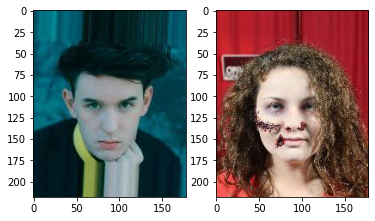

In [27]:
t = show_test(88)

In [28]:
if t == 0:
    print("The target is on the left")
else:
    print("The target is on the right")

The target is on the left


Utterance: she is wearing a necklace


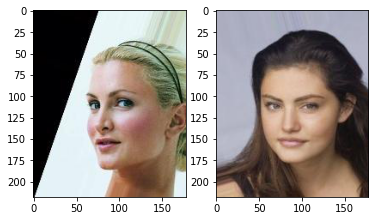

In [36]:
t = show_test(42)

Utterance: he has a goatee <end>


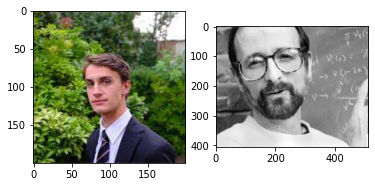

In [33]:
t = show_test_custom("jpiro","dewerpe")

In [37]:
if t == 0:
    print("The target is on the left")
else:
    print("The target is on the right")

The target is on the right


In [46]:
gru_encoder = GRU_Encoder(512, 512, vocab_size)
encoder_l = CNN_Encoder(512)
optimizer_l = tf.keras.optimizers.Adam()
loss_object_l = tf.keras.losses.CategoricalCrossentropy()

loss_plot_l = []

#Load Pre-Trained Listener Model
l_checkpoint_path = "./checkpointslistener/train"
l_ckpt = tf.train.Checkpoint(encoder_l=encoder_l,
                             gru_encoder=gru_encoder,
                             optimizer_l=optimizer_l)
l_ckpt_manager = tf.train.CheckpointManager(l_ckpt, l_checkpoint_path, max_to_keep=30)
# l_ckpt.restore(l_ckpt_manager.latest_checkpoint)

In [47]:
# @tf.function
def train_step(m, targ, dist):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = gru_encoder.reset_state(batch_size=targ.shape[0])

    with tf.GradientTape() as tape:
        #could be a serious problem -- most likely! Exciting
        features_t = encoder_l(targ)
        features_d = encoder_l(dist)

        v = gru_encoder(m, hidden)
        
        with tape.stop_recording():
            rand_n = random.random()

            if rand_n > 0.5:
                left = features_t
                right = features_d
                y_t = tf.convert_to_tensor([[1,0]]*targ.shape[0],dtype=tf.float32)
            else:
                left = features_d
                right = features_t
                y_t = tf.convert_to_tensor([[0,1]]*targ.shape[0],dtype=tf.float32)
    
        x = tf.norm(tf.keras.layers.dot([left, v],axes=2,normalize=True),axis=(1,2))
        y = tf.norm(tf.keras.layers.dot([right, v],axes=2,normalize=True),axis=(1,2))
        x = tf.reshape(x, (x.shape[0],1))
        y = tf.reshape(y, (y.shape[0],1))
        z = tf.concat([x,y],axis=1)
        y_p = tf.nn.softmax(z)
        loss = loss_object_l(y_t, y_p)

    trainable_variables = encoder_l.trainable_variables + gru_encoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    optimizer_l.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [48]:
EPOCHS = 20

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (targ_tensor, dis_tensor, target)) in enumerate(dataset):
        target = tf.one_hot(target, vocab_size)
        loss = train_step(target, targ_tensor, dis_tensor)
        total_loss += loss
        
        # # if batch % 100 == 0:
        #     print ('Epoch {} Batch {} Loss {:.4f}'.format(
        #     epoch + 1, batch, loss.numpy()))
              
    # storing the epoch end loss value to plot later
    loss_plot_l.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()
      
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Loss 0.364663
Time taken for 1 epoch 117.28126692771912 sec

Epoch 2 Loss 0.224259
Time taken for 1 epoch 121.78778004646301 sec

Epoch 3 Loss 0.141586
Time taken for 1 epoch 124.26925683021545 sec

Epoch 4 Loss 0.093739
Time taken for 1 epoch 126.22176098823547 sec

Epoch 5 Loss 0.067320
Time taken for 1 epoch 125.59679293632507 sec

Epoch 6 Loss 0.049165
Time taken for 1 epoch 127.71358799934387 sec

Epoch 7 Loss 0.038573
Time taken for 1 epoch 124.55101084709167 sec

Epoch 8 Loss 0.033337
Time taken for 1 epoch 125.98002290725708 sec

Epoch 9 Loss 0.028233
Time taken for 1 epoch 129.4666450023651 sec

Epoch 10 Loss 0.025838
Time taken for 1 epoch 138.56635808944702 sec

Epoch 11 Loss 0.024736
Time taken for 1 epoch 140.27320289611816 sec

Epoch 12 Loss 0.023920
Time taken for 1 epoch 136.08246302604675 sec

Epoch 13 Loss 0.023297
Time taken for 1 epoch 138.82031202316284 sec

Epoch 14 Loss 0.023918
Time taken for 1 epoch 140.0693187713623 sec

Epoch 15 Loss 0.023310
Time tak

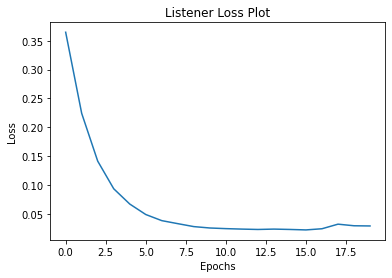

In [50]:
plt.plot(loss_plot_l)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Listener Loss Plot')
plt.show()

In [64]:
def check_understanding(data):
    total_right = 0
    total_wrong = 0

    for (batch, (targ_tensor, dis_tensor, caption)) in enumerate(data):
        hidden_s = decoder.reset_state(batch_size=targ_tensor.shape[0])
        hidden_l = gru_encoder.reset_state(batch_size=targ_tensor.shape[0])

        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

        m = dec_input

        u = tf.concat([targ_tensor, dis_tensor], -1)

        #Encode the image through CNN
        features = encoder(u)

        #make sure that these are 256+256 = 512 and not 32+32 = 64
        for i in range(1,10):
            predictions, hidden, _ = decoder(dec_input, features, hidden_s)
            
            preds = tf.nn.softmax(predictions)
            indices = tf.math.argmax(predictions, axis=1)
            indices = tf.reshape(tf.cast(indices, tf.int32),(targ_tensor.shape[0],1))
            
            m = tf.concat([m, indices],1)

            dec_input = indices

        m = tf.one_hot(m, vocab_size)

        features_t = encoder_l(targ_tensor)
        features_d = encoder_l(dis_tensor)

        rand_n = random.random()

        left = features_t
        right = features_d

        v = gru_encoder(m, hidden_l)

        x = tf.norm(tf.keras.layers.dot([left, v],axes=2,normalize=True),axis=(1,2))
        y = tf.norm(tf.keras.layers.dot([right, v],axes=2,normalize=True),axis=(1,2))

        mask = tf.math.greater(x, y)
        total_right += np.sum(mask.numpy())
        total_wrong += np.sum(mask.numpy()==False)

    total = total_right + total_wrong

    acc = total_right / total

    return acc, total_right, total_wrong

In [65]:
acc, t_r, t_w = check_understanding(tqdm(dataset))

550it [04:28,  2.05it/s]


In [66]:
print(acc, t_r, t_w)

0.9764772727272727 17186 414
